In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-y_y_b_3c
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-y_y_b_3c
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1694556533.224118390420868118806081040175592332373432988400-py3-none-any.whl size=301567 sha256=38ad6fca51f3ace13dca0a79f454020b09c7d0c1132842d97c4a913b27bcdbcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-iogvt14b/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [134]:
# Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Load dataset

The dataset `rooftop` is a subset of this [dataset](https://zenodo.org/record/5171712).
The dataset get uploaded to the Google Colab environment, and then unpacked and added to a dataset.

In [ ]:
!unzip "/content/rooftop_png.zip"

In [ ]:
!zip -r rooftop_new.zip /content/rooftop

In [138]:
#dataset_images = tf.keras.utils.image_dataset_from_directory("/content/rooftop/images", labels=None, shuffle=False, batch_size = 2)
#dataset_masks = tf.keras.utils.image_dataset_from_directory("/content/rooftop/masks", labels=None, shuffle=False, batch_size = 1)
#dataset_masks = tf.keras.utils.image_dataset_from_directory("/content/rooftop/masks", labels=None, shuffle=False, color_mode="rgb", batch_size = 1)
#dataset = tf.data.Dataset.zip((dataset_images, dataset_masks))

images_train, images_test = tf.keras.utils.image_dataset_from_directory(
    "/content/rooftop_png/images",
    labels=None,
    shuffle=True,
    validation_split=0.3,
    subset="both",
    batch_size=None,
    seed=42
    )

masks_train, masks_test = tf.keras.utils.image_dataset_from_directory(
    "/content/rooftop_png/masks",
    labels=None,
    shuffle=True,
    validation_split=0.3,
    subset="both",
    color_mode='grayscale',
    interpolation='nearest',
    batch_size=None,
    seed=42
    )

dataset_train = tf.data.Dataset.zip((images_train, masks_train))
dataset_test = tf.data.Dataset.zip((images_test, masks_test))

Found 138 files belonging to 1 classes.
Using 97 files for training.
Using 41 files for validation.
Found 138 files belonging to 1 classes.
Using 97 files for training.
Using 41 files for validation.


AttributeError: ignored

In [139]:
dataset_train

<_ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))>

In [106]:
def display(display_list):
    """
    Funciton that takes in a list of images to display them next to each other
    for comparision and investigation.

    Args:
        display_list (list): list of images to display
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    plt.show()

In [ ]:
condition = tf.greater(a, 3)
result = tf.where(condition, b, a)

In [113]:
def test(image, mask):

    threshold = 50
    #print(pixel)
    #print(pixel.numpy())
    binary_mask = tf.where(mask > threshold, 1, 0)
    return image, binary_mask

test_dataset_train = dataset_train.map(lambda x, y: (test(x, y)))

#xzy = tf.data.Dataset()


"""
for image, mask in xzy.take(1):
    display([image, mask])
"""

'\nfor image, mask in dataset_train.take(1):\n    #print(list(mask))\n    #display([image, mask])\n    xzy.append(mask)\n\nfor image, mask in xzy.take(1):\n    display([image, mask])\n'

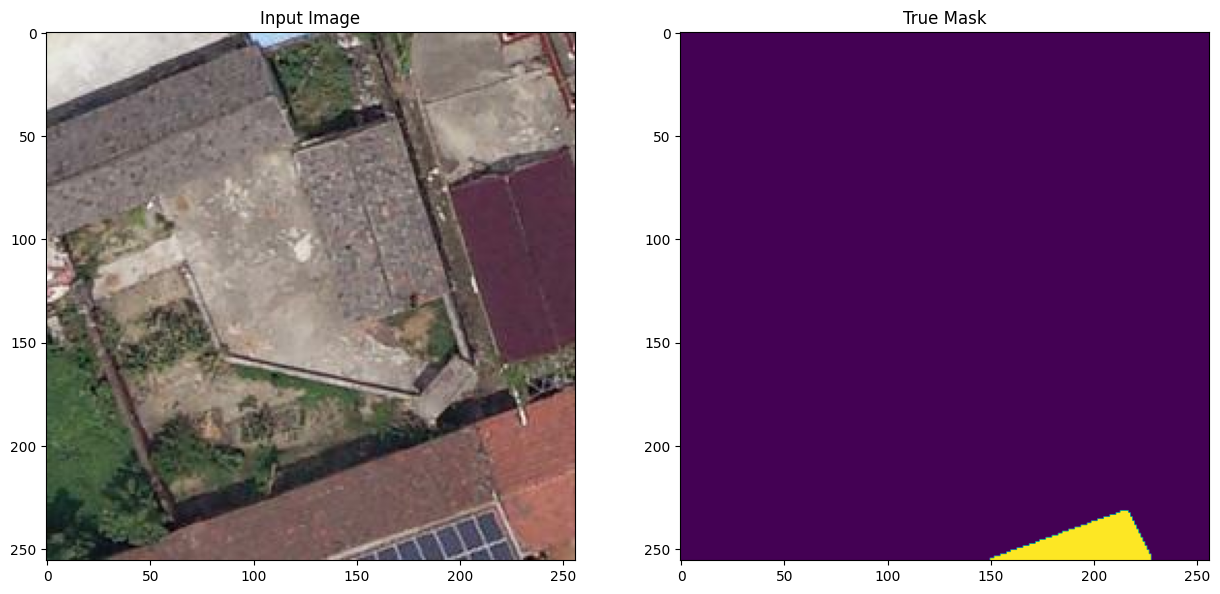

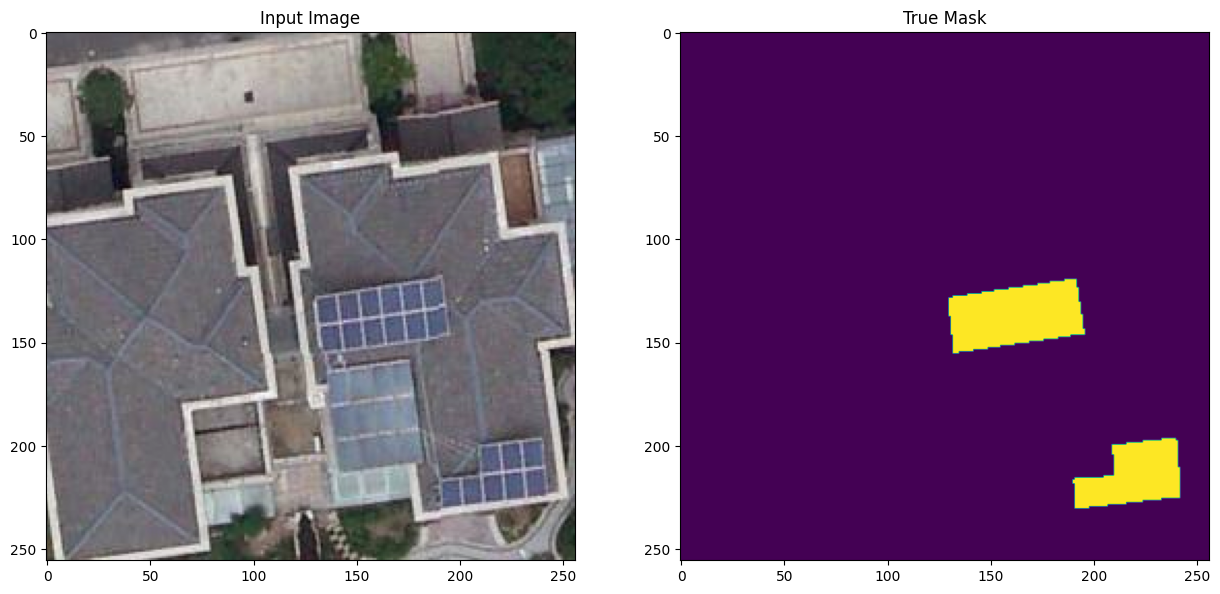

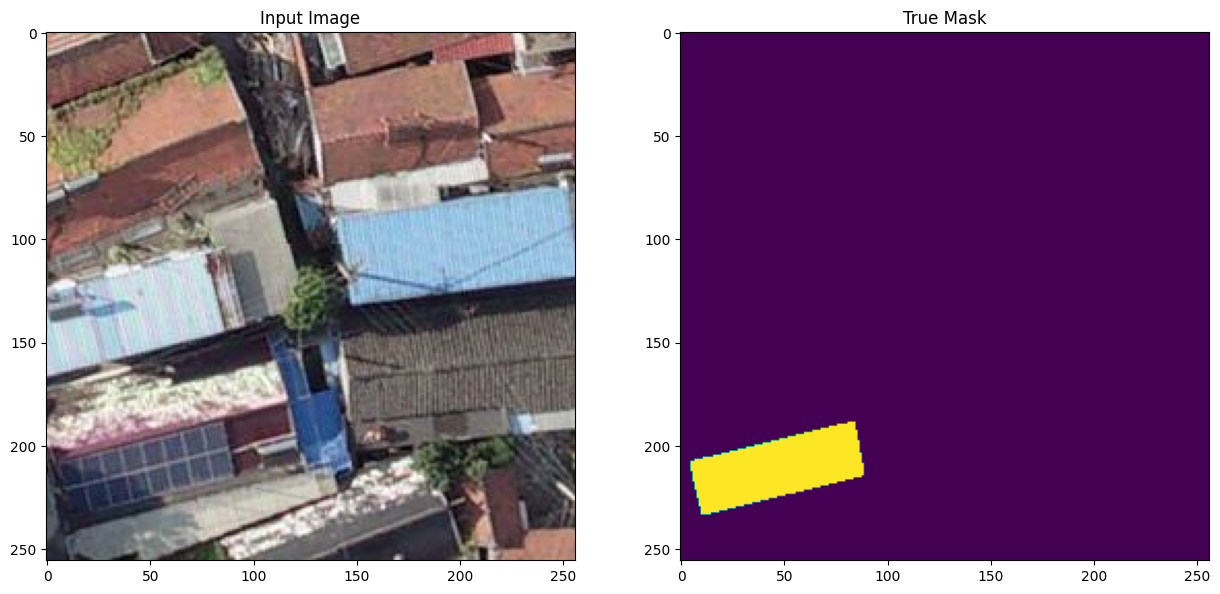

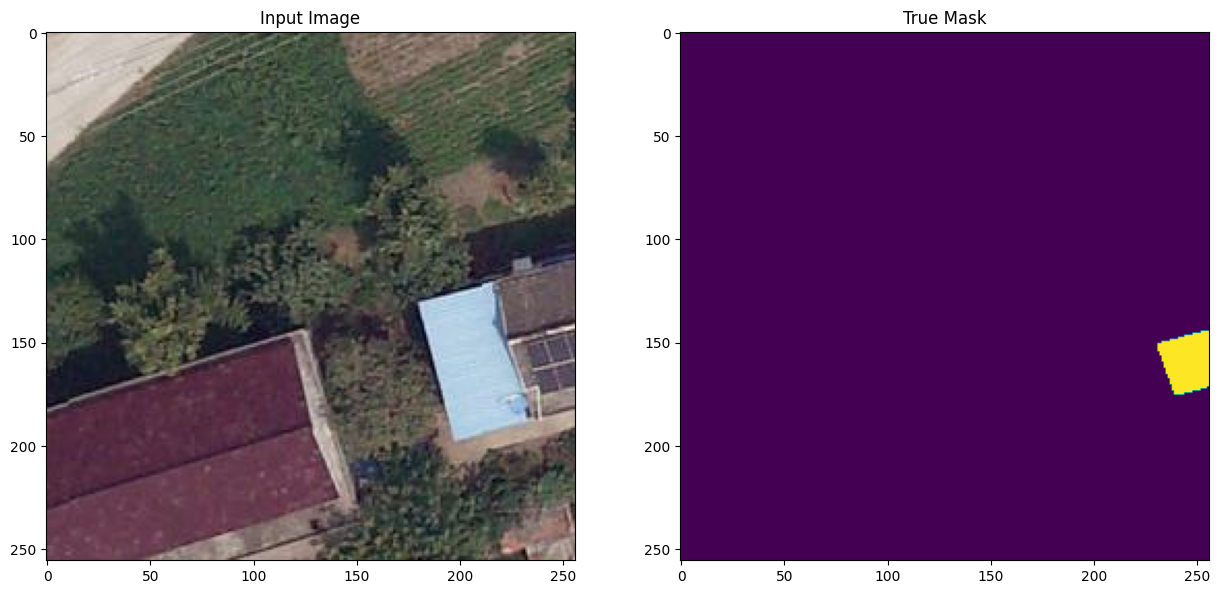

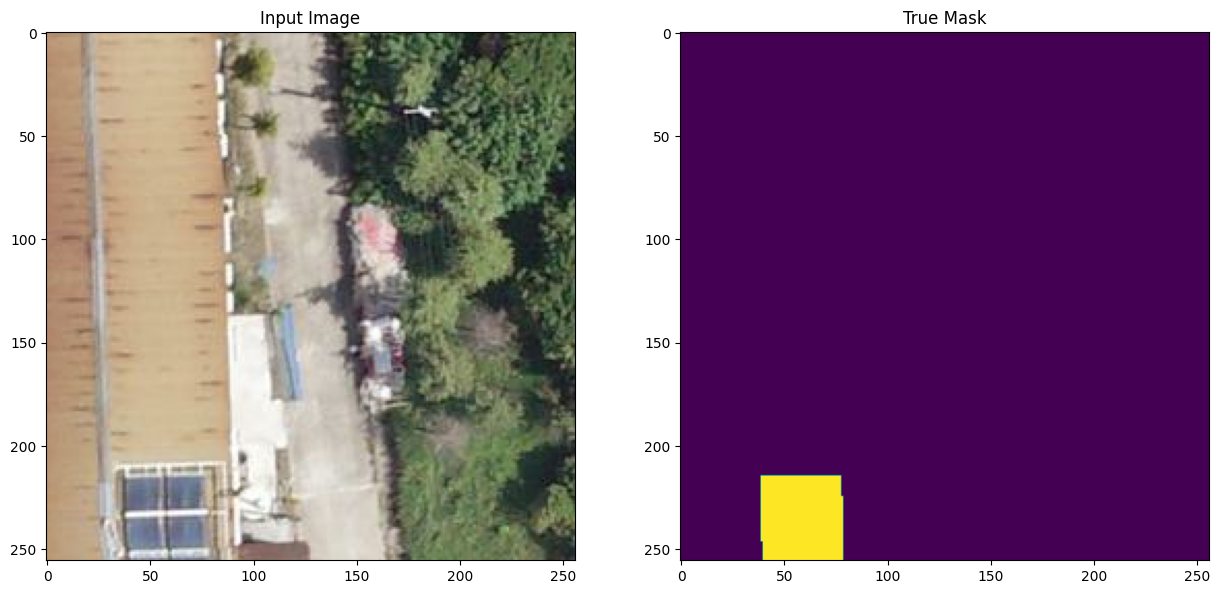

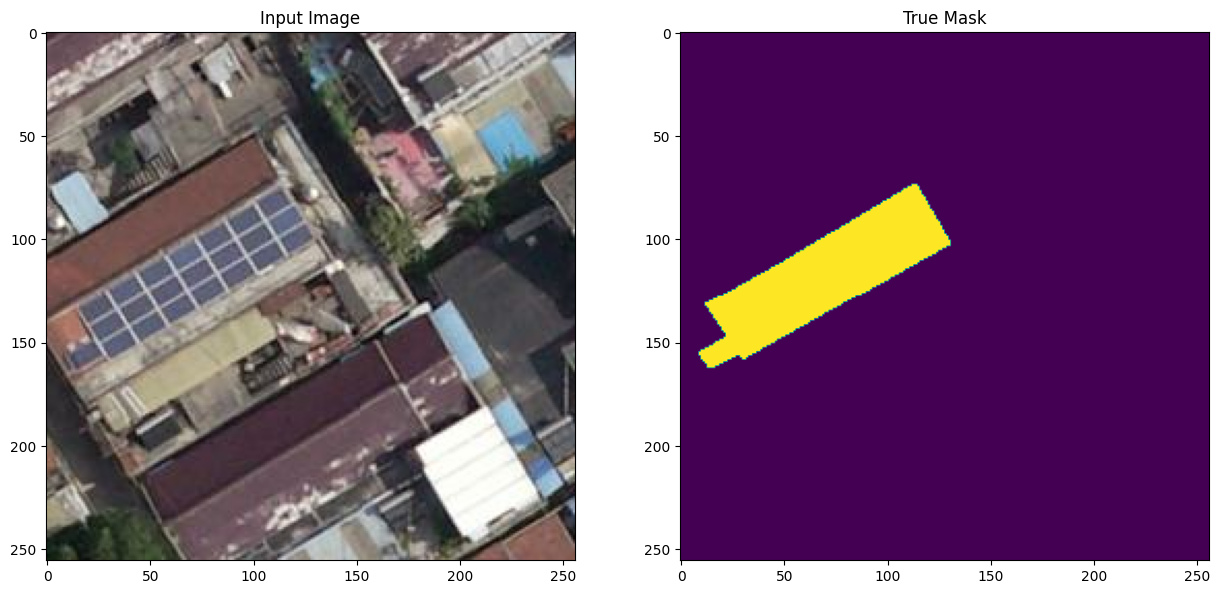

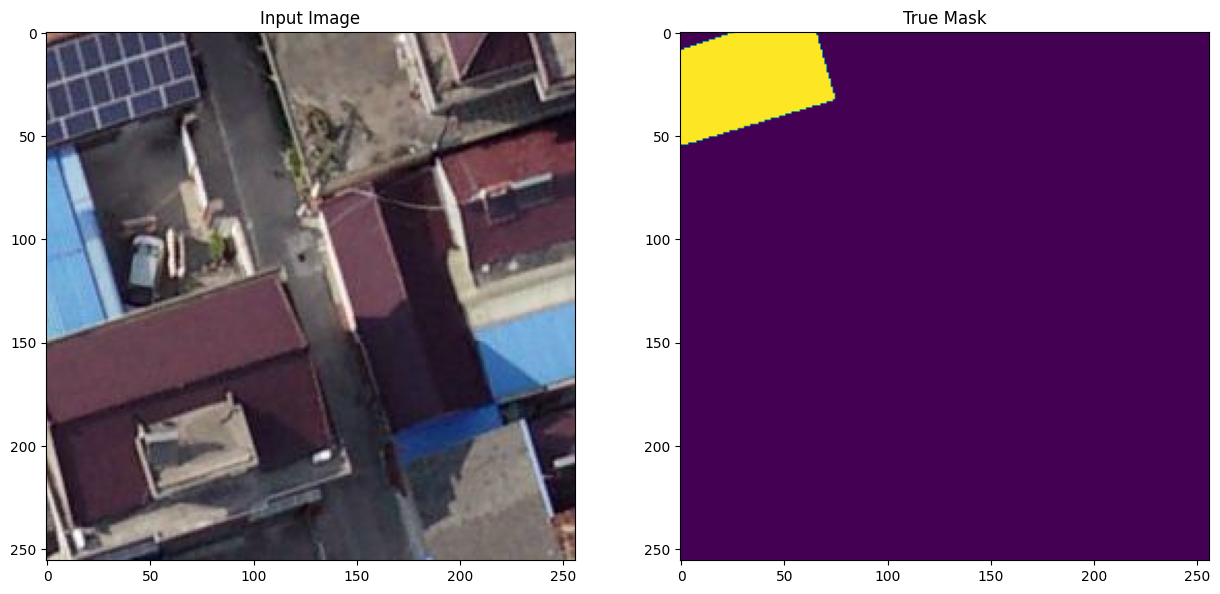

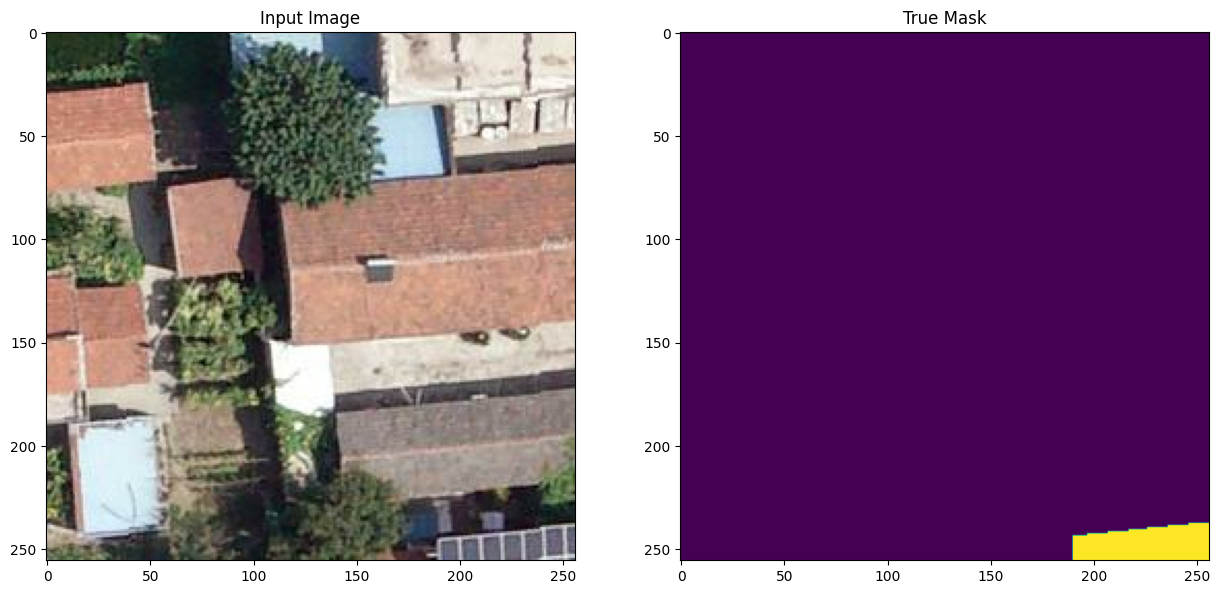

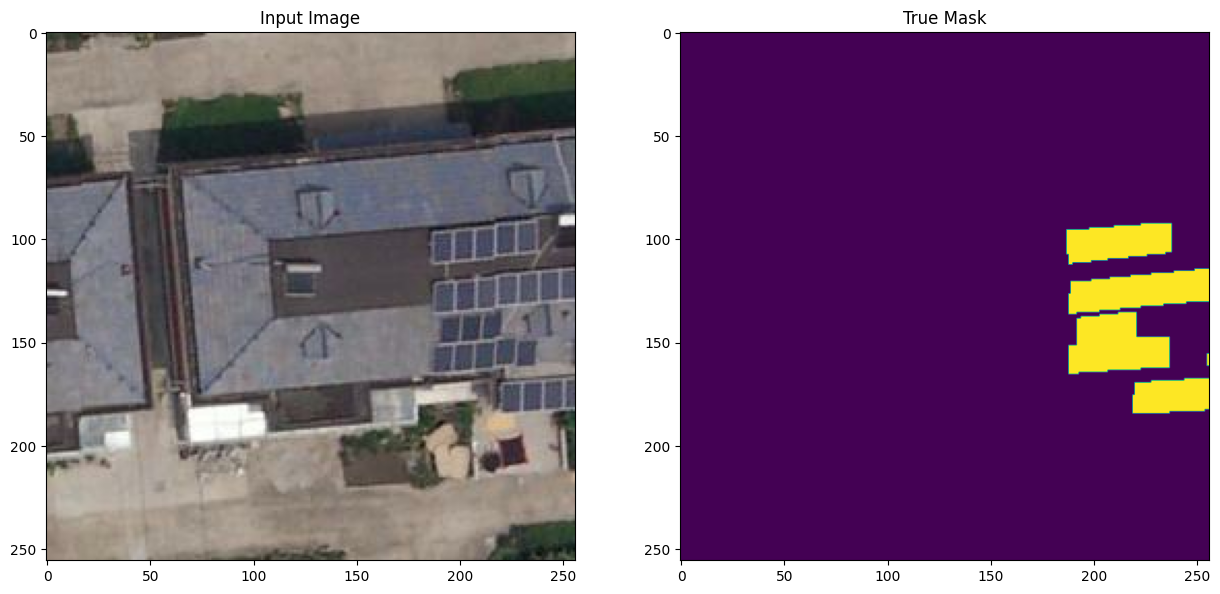

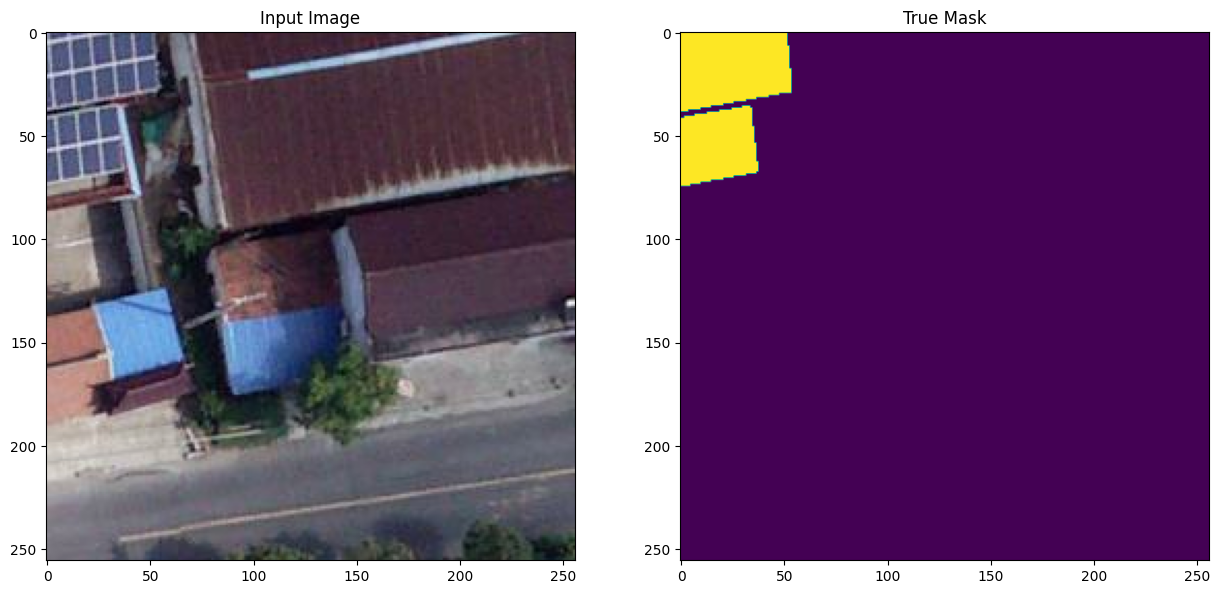

In [140]:
for image, mask in test_dataset_train.take(10):
    #print(list(mask))
    display([image, mask])

# Building out the data pipeline

Now that we have the dataset loaded, we will create pipeline for augmenting and preparing the data for training.

In [126]:
class Preprocess(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.

        # Layers for both
        self.rescaling = tf.keras.layers.Rescaling(1.0/255)

        # Layers for images
        self.resizing_images = tf.keras.layers.Resizing(128, 128, interpolation='bilinear')

        # Layers for masks
        self.resizing_masks = tf.keras.layers.Resizing(128, 128, interpolation='nearest')

    def call(self, images, masks):
        images = self.rescaling(images)
        images = self.resizing_images(images)

        #masks = self.rescaling(masks)
        masks = self.resizing_masks(masks)

        return images, masks

In [127]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        # Layers for images
        self.randomflip_images = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
        self.randomrotation_images = tf.keras.layers.RandomRotation(0.125, fill_mode='constant', interpolation='bilinear', fill_value=0.0, seed=seed)

        # Layers for masks
        self.randomflip_masks = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
        self.randomrotation_masks = tf.keras.layers.RandomRotation(0.125, fill_mode='constant', interpolation='nearest', fill_value=0.0, seed=seed)

    def call(self, images, masks):
        images = self.randomflip_images(images)
        images = self.randomrotation_images(images)
        masks = self.randomflip_masks(masks)
        masks = self.randomrotation_masks(masks)

        return images, masks

In [141]:
train_batches = (
    #dataset_train
    test_dataset_train
    .cache()
    #.shuffle(BUFFER_SIZE)
    .batch(16)
    .repeat()
    .map(Preprocess())
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (
    dataset_test
    .batch(16)
    .map(Preprocess())
)

In [128]:
len(list(test_batches.as_numpy_iterator()))

3

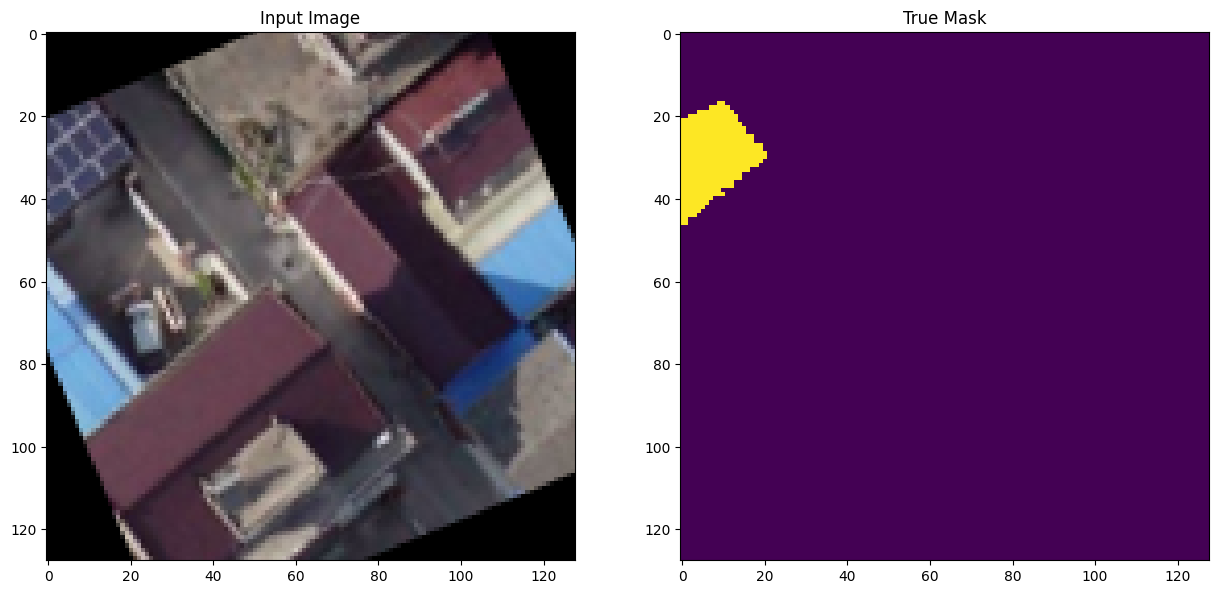

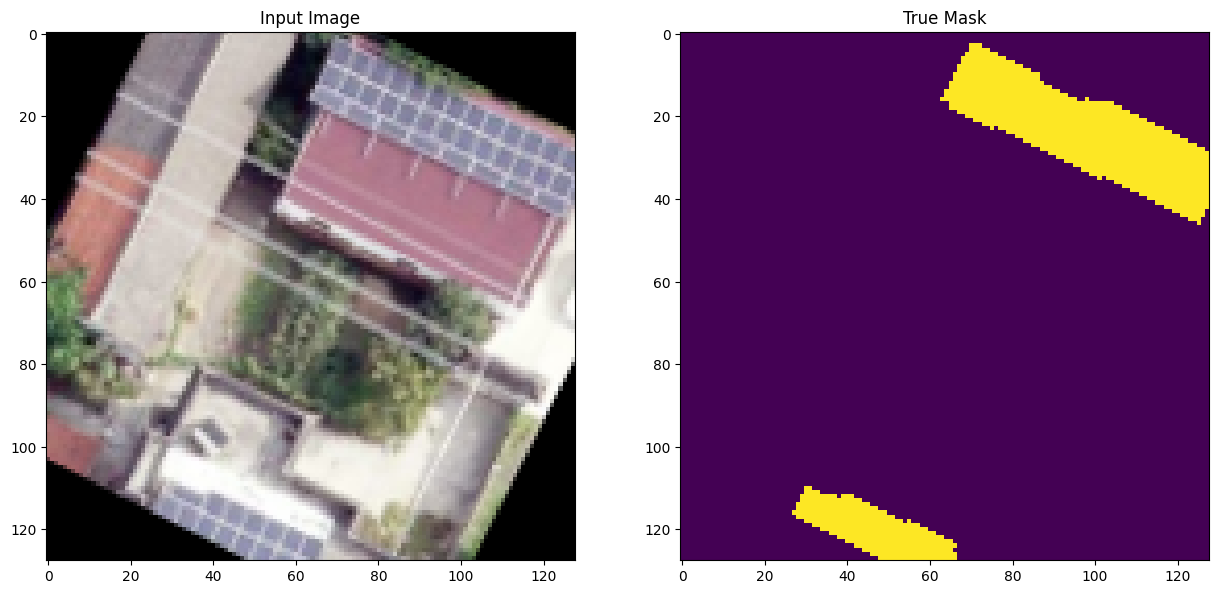

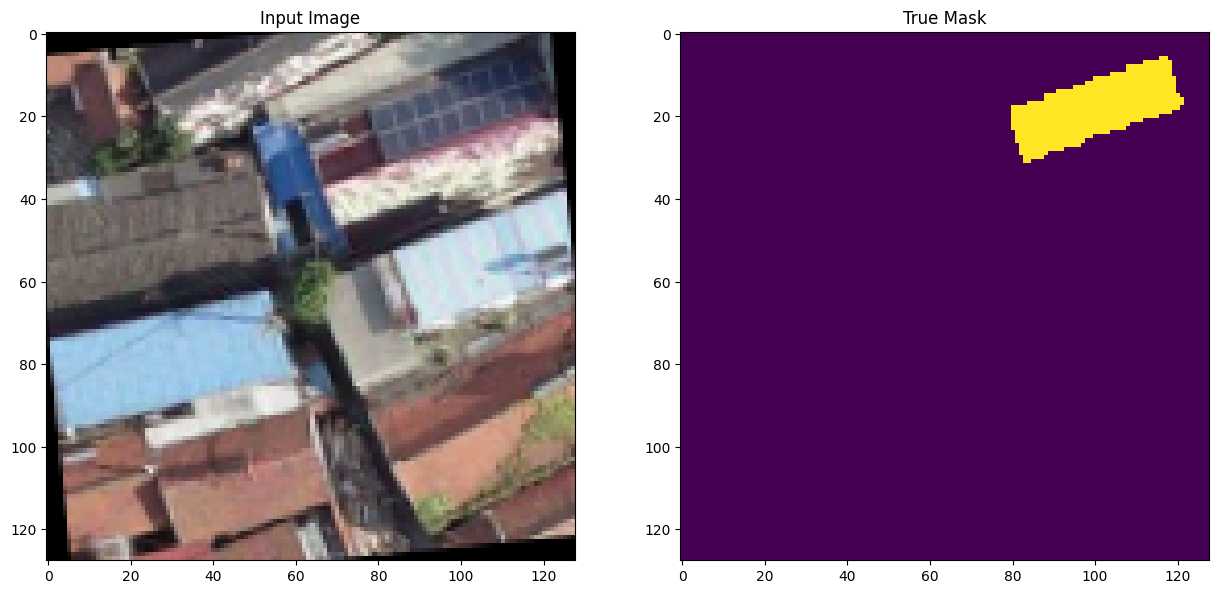

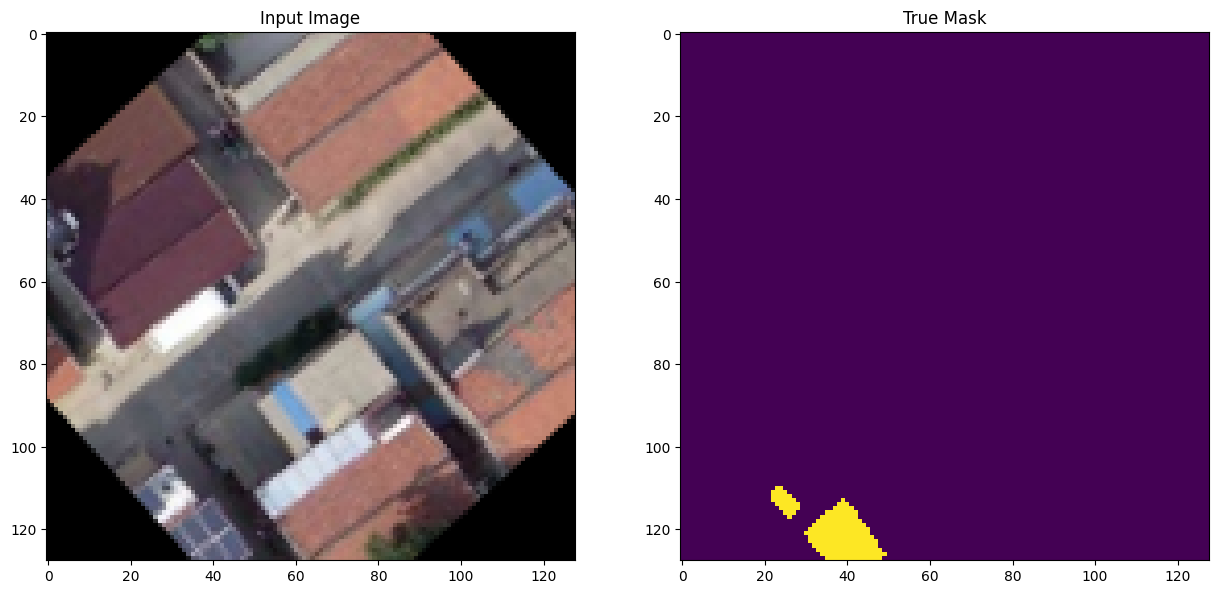

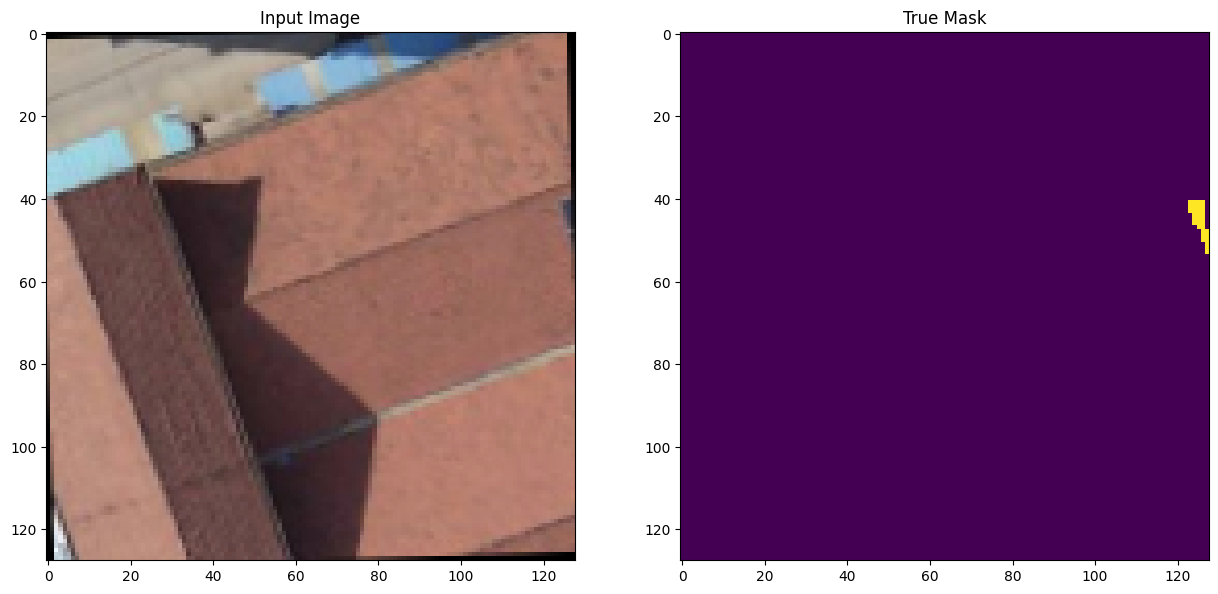

In [142]:
for image, mask in train_batches.take(5):
    #print(mask[0])
    display([image[0], mask[0]])

In [ ]:
# Download dataset
#dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [143]:
#TRAIN_LENGTH = info.splits['train'].num_examples
TRAIN_LENGTH = 97
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [144]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [145]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8 3
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16 3
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32 3
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64 3
]

In [146]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2, #kernel_size=3
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [147]:
OUTPUT_CLASSES = 2#3#2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

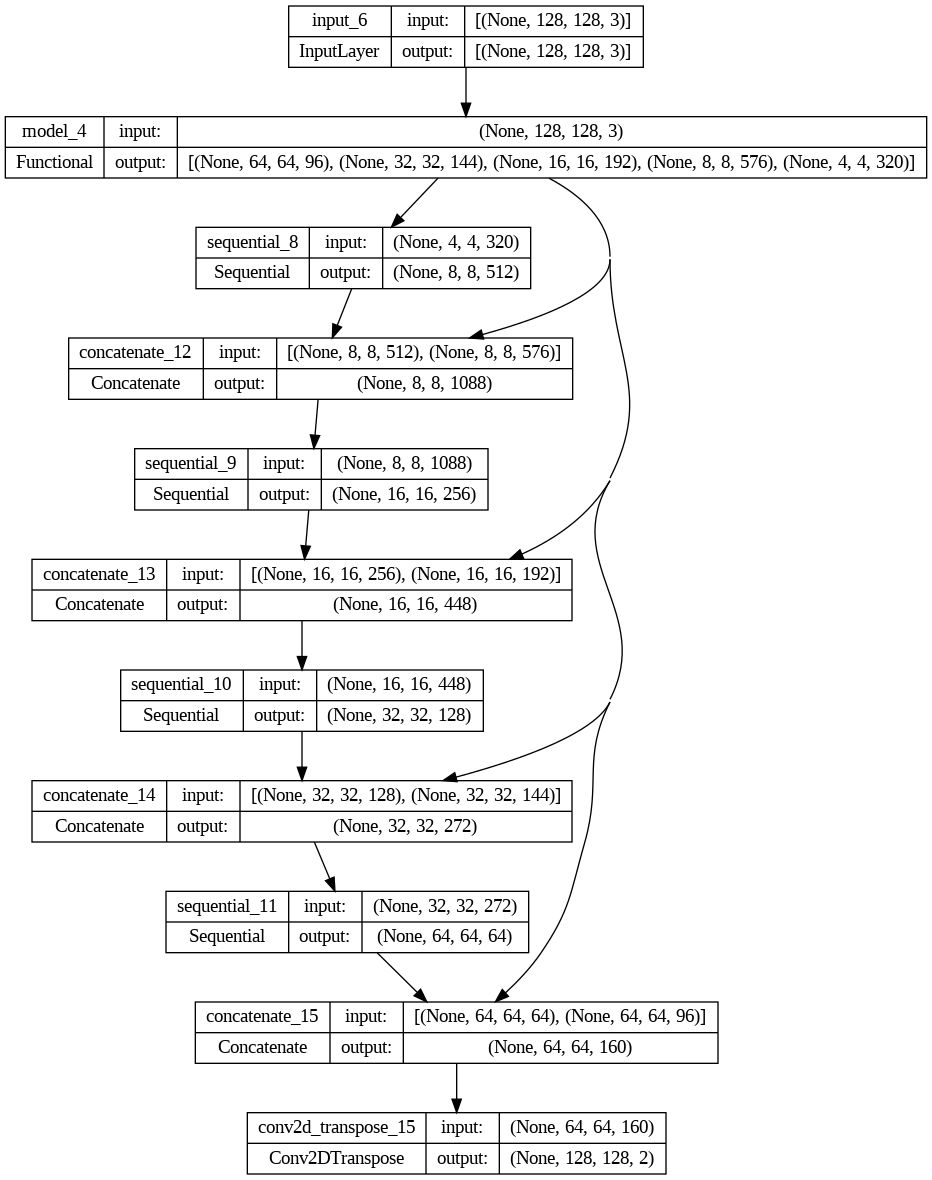

In [148]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [149]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  #display([sample_image, sample_mask])

In [150]:
for image, mask in train_batches.take(1):
      pred_mask = model.predict(image)



1/1 [==============================] - 2s 2s/step


In [60]:
pred_mask[0].shape

(128, 128, 2)

In [61]:
pred_mask = tf.math.argmax(pred_mask[0], axis=-1)
pred_mask

<tf.Tensor: shape=(128, 128), dtype=int64, numpy=
array([[1, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0]])>

In [ ]:
pred_mask = pred_mask[..., tf.newaxis]
pred_mask

In [151]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [152]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 115ms/step


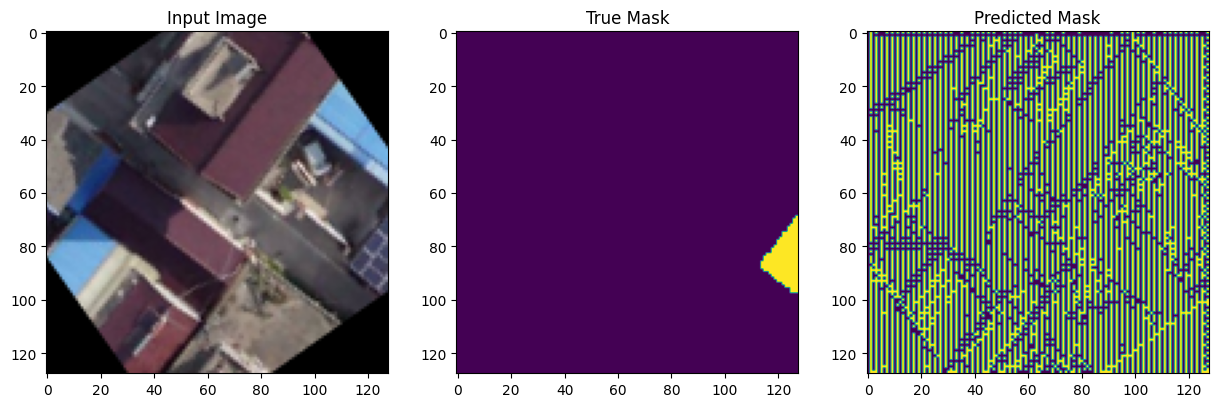

In [153]:
show_predictions()

In [154]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [155]:
for image, mask in train_batches.take(1):
    print(image.shape)
    print(mask.shape)

(16, 128, 128, 3)
(16, 128, 128, 1)


In [67]:
train_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

1/1 [==============================] - 0s 74ms/step


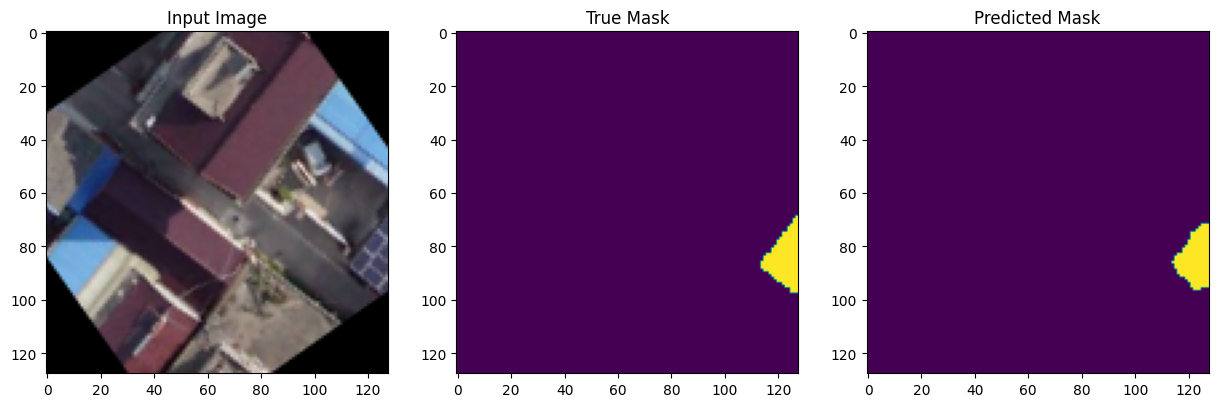


Sample Prediction after epoch 20

6/6 [==============================] - 13s 2s/step - loss: 0.0241 - accuracy: 0.9916


In [161]:
EPOCHS = 20
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = 41//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


In [162]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

KeyError: ignored

1/1 [==============================] - 1s 1s/step


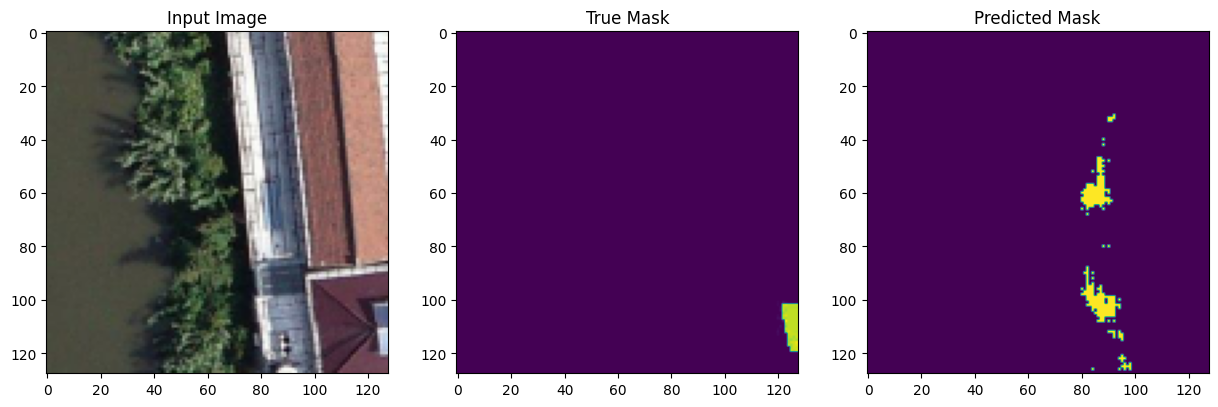

1/1 [==============================] - 1s 704ms/step


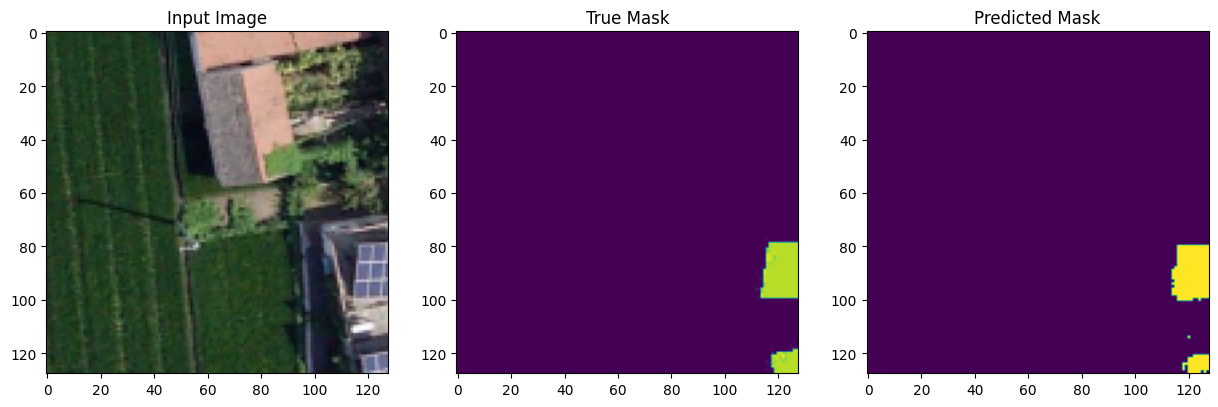

1/1 [==============================] - 0s 370ms/step


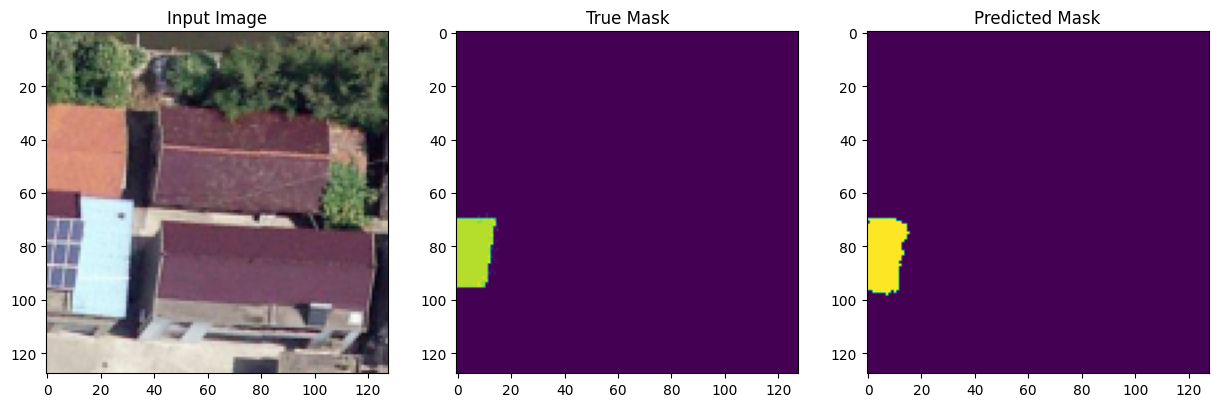

In [164]:
show_predictions(test_batches, 10)

# Old

In [117]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

TypeError: ignored

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [13]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete30TNP0/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete30TNP0/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [188]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmp_jy1lmtvtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [92]:
print(dataset["train"])

for datapoint in dataset["train"]:
    pass#print(datapoint['segmentation_mask'])

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


The segmentation mask has shape (none, none , *1*)

Fpr the PV it has shape (none, none, *3*)

In [199]:
dataset["train"].map(lambda x: print(x["segmentation_mask"]))

Tensor("args_3:0", shape=(None, None, 1), dtype=uint8)


InvalidArgumentError: ignored

In [196]:
type(dataset["train"])

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [26]:
from PIL import Image
import os

# Replace 'input_folder' with the path to the folder containing .bmp files
input_folder = '/content/rooftop/masks'

# Replace 'output_folder' with the path to the folder where you want to save .jpg files
output_folder = '/content/rooftop/masks/png/'

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.bmp'):
        # Open the .bmp file
        with Image.open(os.path.join(input_folder, filename)) as img:
            # Remove the .bmp extension and add .jpg extension for the output file
            output_filename = os.path.splitext(filename)[0] + '.jpg'
            # Save the image as .jpg in the output folder
            img.save(os.path.join(output_folder, output_filename), 'JPEG')

print("Conversion complete.")


Conversion complete.
